In [130]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [131]:
# 加载数据集
data_path = '模型1.csv'
data = pd.read_csv(data_path)

# 选择模型输入的特征，假设我们将使用'Close', 'Open', 'Volume','NClose'作为特征
features = ['Close', 'Open', 'Volume','NClose']
df = data[features]






In [132]:


# 使用.diff()方法进行差分
diff_df = df.diff().dropna()


In [133]:
# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(diff_df)

# 创建多特征时间序列数据集
def create_multifeatured_dataset(dataset, look_back=20, forecast_horizon=5):
    X, Y = [], []
    for i in range(len(dataset) - look_back - forecast_horizon + 1):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[(i + look_back):(i + look_back + forecast_horizon), 0]) # 假设'Close'是预测目标
    return np.array(X), np.array(Y)

look_back = 20
forecast_horizon = 5
X, Y = create_multifeatured_dataset(scaled_data, look_back, forecast_horizon)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# 调整数据形状以适配LSTM模型
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1992, 20, 4), (499, 20, 4), (1992, 5), (499, 5))

In [134]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(forecast_horizon))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, verbose=1)


Epoch 1/100
63/63 [==============================] - 6s 35ms/step - loss: 0.0279 - val_loss: 0.0076
Epoch 2/100
63/63 [==============================] - 1s 22ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 3/100
63/63 [==============================] - 2s 33ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 4/100
63/63 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 5/100
63/63 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 6/100
63/63 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 7/100
63/63 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 8/100
63/63 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 9/100
63/63 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 10/100
63/63 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0074

In [135]:
# 进行预测
predictions = model.predict(X_test)



# 计算RMSE
rmse = np.sqrt(np.mean(predictions - Y_test)**2)
print(f"RMSE: {rmse}")


16/16 [==============================] - 1s 6ms/step
RMSE: 0.0018798152282220352


In [136]:
# 由于我们预测的是未来5天的价格，我们需要对每天的预测进行反标准化
predicted_prices = np.zeros((predictions.shape[0], 5))
for i in range(5):
    predicted_prices[:, i] = scaler.inverse_transform(np.concatenate((predictions[:, i].reshape(-1,1), np.zeros((predictions.shape[0], len(features)-1))), axis=1))[:,0]

# 反标准化实际值需要特别处理，因为Y_test的形状与predictions不同
actual_prices = np.zeros_like(predicted_prices)
for i in range(forecast_horizon):
    actual_prices[:, i] = scaler.inverse_transform(np.concatenate((Y_test[:, i].reshape(-1,1), np.zeros((Y_test.shape[0], len(features)-1))), axis=1))[:,0]

In [137]:
print(predicted_prices)

[[ 3.23896473e-01 -2.43977248e-01 -2.55676924e-01 -1.33078580e-01
  -2.79612425e-01]
 [ 1.78635396e-01  5.35171578e-02 -3.87993529e-01  1.75043458e-02
  -4.74185110e-01]
 [ 1.79590880e+00 -1.97879755e-03 -2.69397645e-01 -6.47360584e-02
  -3.70694605e-01]
 ...
 [-1.54181964e+00  2.29168488e-01 -4.57368719e-01  1.70299464e-01
  -4.77688719e-01]
 [-3.17506558e+00  2.60682321e-01 -5.14582678e-01  2.51031662e-01
  -4.81117733e-01]
 [ 7.81626796e-01 -1.35377022e-01 -1.95001316e-01 -6.11788346e-02
  -2.61381070e-01]]


In [138]:
print(actual_prices)

[[-0.742004 -0.804001 -0.089005 -4.673996  1.561005]
 [-0.804001 -0.089005 -4.673996  1.561005  2.050491]
 [-0.089005 -4.673996  1.561005  2.050491  2.021012]
 ...
 [-2.340012 -5.959991 -0.210007  2.150009 -5.290001]
 [-5.959991 -0.210007  2.150009 -5.290001  0.      ]
 [-0.210007  2.150009 -5.290001  0.        0.      ]]


In [139]:
df.shape

(2516, 4)

In [140]:

original1 = df['Close'][2016]  # 例如，获取'Close'列差分前的第一个值


In [141]:
original1

159.488998

In [142]:
#恢复差分
predicted_prices_flatten =  predicted_prices[:,-1].flatten()

# 初始化恢复后的预测价格数组，首个元素为差分前的最后一个已知值加上第一个预测差分值
restored_data_predicted_prices = np.zeros_like(predicted_prices_flatten)
restored_data_predicted_prices[0] = original1 + predicted_prices_flatten[0]

# 逐步累加之后的预测差分值
for i in range(1, len(predicted_prices_flatten)):
    restored_data_predicted_prices[i] = restored_data_predicted_prices[i-1] + predicted_prices_flatten[i]


actual_prices_flatten =  actual_prices[:,-1].flatten()

# 初始化恢复后的预测价格数组，首个元素为差分前的最后一个已知值加上第一个预测差分值
restored_data_actual_prices = np.zeros_like(actual_prices_flatten)
restored_data_actual_prices[0] = original1 + actual_prices_flatten[0]

# 逐步累加之后的预测差分值
for i in range(1, len(actual_prices_flatten)):
    restored_data_actual_prices[i] = restored_data_actual_prices[i-1] + actual_prices_flatten[i]

In [143]:
print(actual_prices_flatten[0])

1.561004999999994


In [144]:
original1

159.488998

In [145]:
print(restored_data_actual_prices[0] )

161.050003


In [146]:
print(actual_prices_flatten)

[ 1.5610050e+00  2.0504910e+00  2.0210120e+00 -6.9050600e-01
 -2.1159980e+00  5.1499000e-02  1.8475040e+00  7.7899100e-01
  5.4580080e+00  1.8860020e+00 -1.2950200e-01 -1.4544980e+00
  9.9749800e-01 -4.9730080e+00 -7.5900200e-01  2.7850030e+00
  8.2099900e-01  2.7040100e+00 -3.7070000e+00 -2.7160040e+00
 -2.6800500e-01  3.5625000e+00  4.6500090e+00  2.0994870e+00
 -1.5004880e+00  4.3624880e+00 -4.7090000e+00 -4.7749300e-01
  2.6325070e+00  1.0264900e+00 -2.4899300e-01  4.1499300e-01
  7.3529970e+00 -9.7448800e-01 -5.2000120e+00  3.7350500e-01
  1.8494000e-02 -3.7924960e+00  2.8505090e+00 -2.7250060e+00
 -3.1674950e+00 -3.1800900e-01 -2.3784940e+00  1.8789980e+00
  4.7960050e+00 -6.5000000e-03 -1.9870000e+00 -1.9589990e+00
 -2.6445010e+00 -4.7599800e-01  4.2234950e+00 -4.4440000e+00
  1.1465000e+00 -2.9385070e+00  3.3380120e+00  6.1999600e-01
  3.1494000e-02 -1.3990020e+00  9.9150000e-01 -1.4599910e+00
 -5.5650300e-01 -1.9275060e+00  3.6875000e+00 -2.8824920e+00
 -3.1650080e+00 -1.10299

In [147]:
restored_data_predicted_prices.shape


(499,)

In [148]:
restored_data_actual_prices.shape

(499,)

In [149]:
a_p=restored_data_actual_prices
p_p=restored_data_predicted_prices

In [150]:
a_p

array([161.050003, 163.100494, 165.121506, 164.431   , 162.315002,
       162.366501, 164.214005, 164.992996, 170.451004, 172.337006,
       172.207504, 170.753006, 171.750504, 166.777496, 166.018494,
       168.803497, 169.624496, 172.328506, 168.621506, 165.905502,
       165.637497, 169.199997, 173.850006, 175.949493, 174.449005,
       178.811493, 174.102493, 173.625   , 176.257507, 177.283997,
       177.035004, 177.449997, 184.802994, 183.828506, 178.628494,
       179.001999, 179.020493, 175.227997, 178.078506, 175.3535  ,
       172.186005, 171.867996, 169.489502, 171.3685  , 176.164505,
       176.158005, 174.171005, 172.212006, 169.567505, 169.091507,
       173.315002, 168.871002, 170.017502, 167.078995, 170.417007,
       171.037003, 171.068497, 169.669495, 170.660995, 169.201004,
       168.644501, 166.716995, 170.404495, 167.522003, 164.356995,
       163.253998, 162.554001, 161.485992, 165.362   , 165.207001,
       161.214005, 162.138   , 158.917496, 156.298996, 151.667

In [151]:
p_p

array([159.20938557, 158.73520047, 158.36450586, 157.70917041,
       157.4890867 , 156.99879851, 156.62725539, 156.0225253 ,
       155.51156978, 155.10613046, 154.76545547, 154.48009461,
       154.06050799, 153.72001948, 153.36732079, 152.95724031,
       152.66722662, 152.2406118 , 152.06863453, 151.74553353,
       151.40577465, 151.25494026, 150.84800672, 150.68596684,
       150.34960201, 150.1341012 , 149.85745391, 149.49910235,
       149.11665213, 148.71460453, 148.22788056, 148.02814949,
       147.73692597, 147.31636263, 147.00802201, 146.57198497,
       146.30126561, 145.95882133, 145.42972769, 145.10800436,
       144.81745685, 144.24159948, 144.21050553, 143.57329187,
       143.10051007, 142.84987759, 142.22500932, 141.95994282,
       141.87427369, 141.25873439, 140.6216839 , 140.41762169,
       139.84389492, 139.42635033, 139.41220098, 138.68090504,
       138.37621955, 137.83868275, 137.81641659, 137.34694492,
       136.9399298 , 136.65946653, 136.1491777 , 135.79

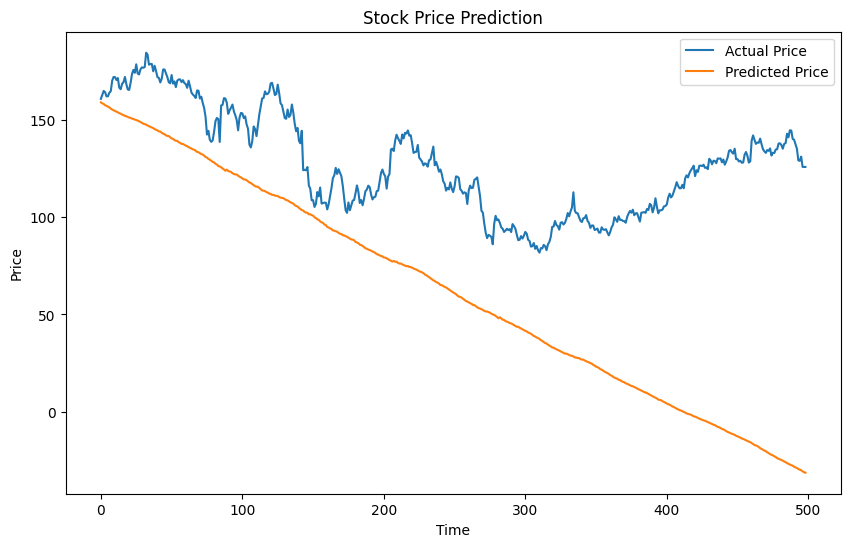

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(a_p, label='Actual Price')
plt.plot(p_p, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [154]:
start_index = np.random.randint(0, Y_test.shape[0] - 5)
indices = np.arange(start_index, start_index + 5)

indices

array([380, 381, 382, 383, 384])

In [160]:
print(p_p[indices])

[11.50516681 11.09064795 10.84454476 10.46069822 10.0862972 ]


In [163]:
print(a_p[indices])

[ 99.919998  97.830002 102.400002 102.510002 102.739998]


In [168]:
print(p_p[-5:])

[-29.91856713 -30.30882414 -30.78651285 -31.26763059 -31.52901166]


In [167]:
print(a_p[-5:])

[129.119995 131.270004 125.980003 125.980003 125.980003]
